In [3]:
import torch
from torch import nn
import torch.nn.functional as F
import librosa
import numpy as np
import pdb
import matplotlib.pyplot as plt
import librosa.display
from scipy.io.wavfile import write

/home/mia.chiquier/.conda/envs/music-synth/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
class Envelope(nn.Module):
    def __init__(self, slope, offset, min_slope=-2.0, max_slope=8.0):
        super().__init__()

        self.slope = slope
        self.offset = offset
        self.min_slope = min_slope
        self.max_slope = max_slope

    def forward(self, t):
        slope = 2.0 ** (
            torch.sigmoid(self.slope) * (self.max_slope - self.min_slope)
            + self.min_slope
        )
        offset = torch.tanh(self.offset) / 2

        t = t / t.max() - 0.5
        bell = 1 / torch.sqrt(
            (
                1
                + (
                    ((t.reshape([-1, 1]) @ slope.reshape([1, -1])) + (slope * offset))
                    ** 2
                )
            )
        )
        return bell


In [5]:

class Synth:
    def __init__(self, device):
        self.device = device

    def fit(
        self,
        target,
        sr,
        minimize_num_freqs=False,
        carrier_stereo_detune=0.0,
        mod_stereo_detune=0.0,
        time_stretch=1,
        learning_rate=0.01,
        n_iter=1000,
        out_sr=44100,
    ):
        if len(target.shape) == 2:
            target = target[:, 0]
        target = torch.tensor(target).to(self.device).to(torch.float32)
        target -= torch.mean(target)
        target /= torch.max(torch.abs(target))
        dur = len(target) / sr
        if dur > 5:
            raise ValueError("Duration must be less than 5 seconds")

        t = torch.linspace(0, dur, len(target)).to(self.device)

        net = FMNet().to(self.device)
        loss_fn = nn.MSELoss()
        optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
        for i in range(n_iter):
            optimizer.zero_grad()
            out = net(t)
            carrier_spiky = torch.sum(net.carrier_weights_ ** 2)
            mod_spiky = torch.sum(net.mod_weights_ ** 2)
            sig_loss = loss_fn(out, target)
            if minimize_num_freqs:
                loss = sig_loss * 100 - carrier_spiky - mod_spiky
            else:
                loss = sig_loss
            loss.backward()
            if i % 100 == 0:
                print(
                    f"i: {i}, sig_loss: {sig_loss.item():.3f}, carrier_spiky: {carrier_spiky.item():.3f}, mod_spiky: {mod_spiky.item():.3f}"
                )
            optimizer.step()

        out = self.make_output(
            net, dur * time_stretch, out_sr, carrier_stereo_detune, mod_stereo_detune
        )

        del net

        return out

    def make_output(self, net, dur, sr, carrier_stereo_detune, mod_stereo_detune):
        t2 = torch.linspace(0, dur, int(dur * sr)).to(self.device)
        carrier_fq = net.carrier_fq

        left = net(t2)
        right = net(t2)

        out = torch.vstack([left, right]).T.cpu().detach().numpy()

        net.carrier_fq.data = carrier_fq

        # remove clicks
        n_fade = 100
        out[:n_fade] *= np.repeat(np.linspace(0, 1, n_fade).reshape([-1, 1]), 2, axis=1)
        out[-n_fade:] *= np.repeat(
            np.linspace(1, 0, n_fade).reshape([-1, 1]), 2, axis=1
        )

        # normalize
        out /= np.max(out)

        return out


In [6]:
class SynthNormalized:
    def __init__(self, device):
        self.device = device

    def get_prepared_values(self,carrier_weight, mod_weight,carrier_env_slope, carrier_env_offset,mod_env_slope,mod_env_offset,phase_offset):

        min_slope=-2.0
        max_slope=8.0
        carrier_env_slope = 2.0 ** carrier_env_slope * (max_slope - min_slope)+ min_slope
        mod_env_slope = 2.0 ** mod_env_slope * (max_slope - min_slope)+ min_slope
        carrier_env_offset = carrier_env_offset / 2
        mod_env_offset = mod_env_offset / 2
        phase_offset = 2 * np.pi * phase_offset

        return carrier_weight, mod_weight,carrier_env_slope, carrier_env_offset,mod_env_slope,mod_env_offset,phase_offset

    def make_output(self, net,variables,sr, carrier_stereo_detune, mod_stereo_detune):
        
        (dur,carrier_weight, mod_weight,carrier_env_slope, carrier_env_offset,mod_env_slope,mod_env_offset,phase_offset) = variables
        t2 = torch.linspace(0, dur, int(dur * sr)).to(self.device)
        carrier_weight, mod_weight,carrier_env_slope, carrier_env_offset,mod_env_slope,mod_env_offset,phase_offset = self.get_prepared_values(carrier_weight, mod_weight,carrier_env_slope, carrier_env_offset,mod_env_slope,mod_env_offset,phase_offset)
        carrier_fq = net.carrier_fq
        left = net(t2,carrier_weight, mod_weight,carrier_env_slope, carrier_env_offset,mod_env_slope,mod_env_offset,phase_offset)
        right = net(t2,carrier_weight, mod_weight,carrier_env_slope, carrier_env_offset,mod_env_slope,mod_env_offset,phase_offset)

        out = torch.vstack([left, right]).T.cpu().detach().numpy()

        net.carrier_fq.data = carrier_fq

        # remove clicks
        n_fade = 100
        out[:n_fade] *= np.repeat(np.linspace(0, 1, n_fade).reshape([-1, 1]), 2, axis=1)
        out[-n_fade:] *= np.repeat(
            np.linspace(1, 0, n_fade).reshape([-1, 1]), 2, axis=1
        )

        # normalize
        out /= np.max(out)

        return out


In [7]:
class EnvelopeNormalized(nn.Module):
    def __init__(self, slope, offset, min_slope=-2.0, max_slope=8.0):
        super().__init__()

        self.slope = slope
        self.offset = offset

    def forward(self, t):

        t = t / t.max() - 0.5
        bell = 1 / torch.sqrt(
            (
                1
                + (
                    ((t.reshape([-1, 1]) @ self.slope.reshape([1, -1])) + (self.slope * self.offset))
                    ** 2
                )
            )
        )
        return bell

In [8]:
class FMNet(nn.Module):
    def __init__(self, carrier_fq, carrier_weight, mod_fq, mod_weight, 
            phase_offset, carrier_env_slope, carrier_env_offset, mod_env_slope, mod_env_offset):
        super().__init__()
        self.carrier_fq = carrier_fq
        self.carrier_weight = carrier_weight 
        self.mod_fq = mod_fq
        self.mod_weight = mod_weight
        self.carrier_env = Envelope(carrier_env_slope, carrier_env_offset)

        self.mod_env = Envelope(mod_env_slope, mod_env_offset)

        self.phase_offset = phase_offset

    def forward(self, t, ):
        self.phase_offset_ = 2 * np.pi * torch.sigmoid(self.phase_offset)

        self.mod_phases_ = (
            2 * np.pi * self.mod_fq.reshape([-1, 1]) @ t.reshape([1, -1])
            + self.phase_offset_
        )
        self.mod_waves_ = torch.cos(self.mod_phases_)
        self.mod_weights_ = F.softmax(self.mod_weight)
        self.mod_amps_ = self.mod_env(t) * self.mod_weights_
        # self.mod_amps_ = self.mod_weights_
        self.mods_ = (self.mod_waves_.T * self.mod_amps_).T
        self.mod_ = torch.sum(self.mods_, axis=0)

        self.carrier_phases_ = (
            2 * np.pi * self.carrier_fq.reshape([-1, 1]) @ t.reshape([1, -1])
            + self.mod_
            + self.phase_offset_
        )
        self.carrier_waves_ = torch.sin(self.carrier_phases_)
        self.carrier_weights_ = F.softmax(self.carrier_weight)
        self.carrier_amps_ = self.carrier_env(t) * self.carrier_weights_
        # self.carrier_amps_ = self.carrier_weights_
        self.carriers_ = (self.carrier_waves_.T * self.carrier_amps_).T
        self.carrier_ = torch.sum(self.carriers_, axis=0)

        return self.carrier_

In [9]:
class FMNetNormalized(nn.Module):
    def __init__(self, carrier_fq):
        super().__init__()
        self.carrier_fq = carrier_fq
        self.mod_fq = torch.tensor([0.25])

    def forward(self, t, carrier_weight, mod_weight, 
            phase_offset, carrier_env_slope, carrier_env_offset, mod_env_slope, mod_env_offset):

        self.carrier_weight = carrier_weight 
        self.mod_weight = mod_weight
        self.carrier_env = EnvelopeNormalized(carrier_env_slope, carrier_env_offset)
        self.mod_env = EnvelopeNormalized(mod_env_slope, mod_env_offset)
        self.phase_offset_ = phase_offset.reshape([-1,1])
        
        self.mod_phases_ = (2 * np.pi * self.mod_fq.reshape([-1, 1]) @ t.reshape([1, -1]) + self.phase_offset_)
        self.mod_waves_ = torch.cos(self.mod_phases_)
        self.mod_weights_ = F.softmax(self.mod_weight)
        self.mod_amps_ = self.mod_env(t) * self.mod_weights_
        # self.mod_amps_ = self.mod_weights_
        self.mods_ = (self.mod_waves_.T * self.mod_amps_).T
        self.mod_ = torch.sum(self.mods_, axis=0)

        self.carrier_phases_ = (
            2 * np.pi * self.carrier_fq.reshape([-1, 1]) @ t.reshape([1, -1])
        )
        self.carrier_waves_ = torch.sin(self.carrier_phases_)
        self.carrier_weights_ = F.softmax(self.carrier_weight)
        self.carrier_amps_ = self.carrier_env(t) * self.carrier_weights_
        # self.carrier_amps_ = self.carrier_weights_
        self.carriers_ = (self.carrier_waves_.T * self.carrier_amps_).T
        self.carrier_ = torch.sum(self.carriers_, axis=0)

        return self.carrier_

[0.]
16641.0 hi
[0.]
(88200,)
torch.Size([129, 690, 2])
/home/mia.chiquier/.conda/envs/music-synth/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/mia.chiquier/.conda/envs/music-synth/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/mia.chiquier/.conda/envs/music-synth/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Pass sr=44100 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  


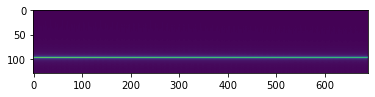

In [34]:

for i in range(1):
    test = np.arange(0.0,22050.0,129)
    hot_encoding = torch.zeros(test.shape)
    index=129
    torch.rand(1)
    hot_encoding[index] = 1.0
    
    carrier_hz = test[index]

    mod_hz = np.array([0.0])
    print(mod_hz)
    print(carrier_hz, "hi")
    print(mod_hz)
    n_freqs=1
    carrier_fq = nn.Parameter(
                    torch.tensor(carrier_hz).to(torch.float32), requires_grad=True
                )
    mod_fq = nn.Parameter(
                    torch.tensor(mod_hz).to(torch.float32), requires_grad=True
                )
    carrier_weight = nn.Parameter(torch.randn(carrier_fq.shape))


    carrier_env_slope = nn.Parameter(torch.rand(n_freqs))
    carrier_env_offset = nn.Parameter(torch.rand(n_freqs))
    mod_env_slope = nn.Parameter(torch.rand(n_freqs))
    mod_env_offset = nn.Parameter(torch.rand(n_freqs))
    mod_weight = nn.Parameter(torch.rand(mod_fq.shape))
    phase_offset=  nn.Parameter(torch.tensor([0.0]))

    fmnet = FMNetNormalized(carrier_fq)
    synth = SynthNormalized('cpu')
    dur=2.0
    sr=44100
    carrier_stereo_detune=0.005
    mod_stereo_detune=0.00001
    variables=(dur,carrier_weight, mod_weight,carrier_env_slope, carrier_env_offset,mod_env_slope,mod_env_offset,phase_offset)
        
    output = synth.make_output(fmnet, variables, 44100, carrier_stereo_detune, mod_stereo_detune)[:,0]
    

    """fmnet = FMNet(carrier_fq, carrier_weight, carrier_fq, mod_weight, 
        phase_offset, carrier_env_slope, carrier_env_offset, mod_env_slope, mod_env_offset)
    synth = Synth('cpu')
    sr=44100
    carrier_stereo_detune=0.005
    mod_stereo_detune=0.00001
    output = synth.make_output(fmnet, 2, sr, carrier_stereo_detune, mod_stereo_detune)"""
    #spec = get_melspec(torch.tensor(output[:,0]),'cpu')

    print(output.shape)

    out = get_melspec(torch.tensor(output),'cpu')
    plt.figure()
    plt.imshow(out.numpy())
    #librosa.display.specshow(out.numpy(),sr=44100, x_axis='time',y_axis='linear',hop_length=256, )
    #plt.colorbar()

    #plt.figure()
    #plt.imsave("test2.png", out.numpy())
    #write("testing/carrier" + str(50)+ "_mod_" + str(5) + ".wav", sr, output)

In [ ]:
out.shape

In [24]:
def get_melspec(audio, device):
    mel_basis = librosa.filters.mel(44100,n_fft=441*4,n_mels=128)
    mel_basis = torch.from_numpy(mel_basis).float().to(device)
    stft = torch.stft(audio,n_fft=441*4,hop_length=441*2)
    print(stft.shape)
    real_part, imag_part = stft.unbind(-1)
    magnitude_concat = torch.sqrt(real_part ** 2 + imag_part ** 2)
    mel_output = torch.matmul(mel_basis, magnitude_concat.float())
    log_mel_spec_concat = torch.log10(torch.clamp(mel_output, min=1e-5))#(1,128,529)
    return log_mel_spec_concat

In [ ]:
def get_melspec(audio, device):
    mel_basis = librosa.filters.mel(44100,n_fft=441*4,n_mels=128)
    mel_basis = torch.from_numpy(mel_basis).float().to(device)
    stft = torch.stft(audio,n_fft=441*4,hop_length=512)
    real_part, imag_part = stft.unbind(-1)
    magnitude_concat = torch.sqrt(real_part ** 2 + imag_part ** 2)
    mel_output = torch.matmul(mel_basis, magnitude_concat.float())
    log_mel_spec_concat = torch.log10(torch.clamp(mel_output, min=1e-5))#(1,128,529)
    return magnitude_concat